In [5]:
import polars as pl
import matplotlib.pyplot as plt



In [6]:

ruta_parquet = "data/opiniones_lugar_turistico.parquet"
df_reseñas = pl.scan_parquet(ruta_parquet)


print(f"{df_reseñas.collect()['opinión'][:5]}")
print(f" Columnas: {df_reseñas.collect().columns}")

shape: (5,)
Series: 'opinión' [str]
[
	""Basílica muy bien conservada,…
	""The Basilica (Guanajuato does…
	""Edificio de la iglesia amaril…
	""A must see place in town and …
	""Not particularly impressive, …
]
 Columnas: ['género', 'edad', 'nacional_ó_internacional', 'calificación', 'escala', 'número_de_aportaciones', 'título_de_la_opinión', 'opinión', 'país', 'idioma', 'dispositivo', 'fecha', 'lugar_turistico', 'calificacion_numerica']


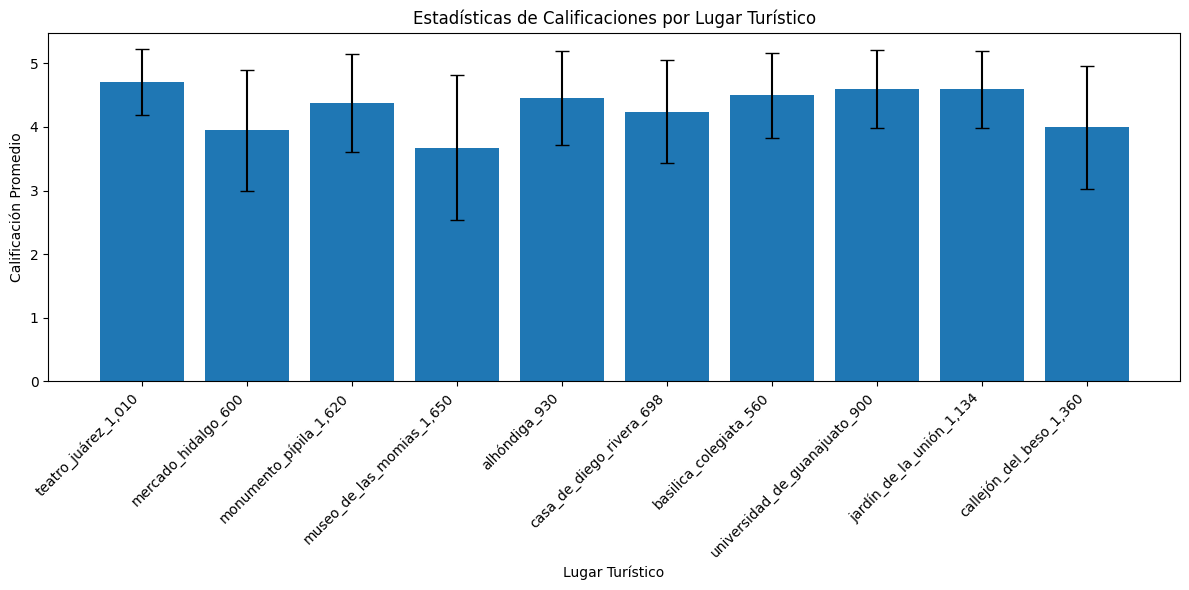

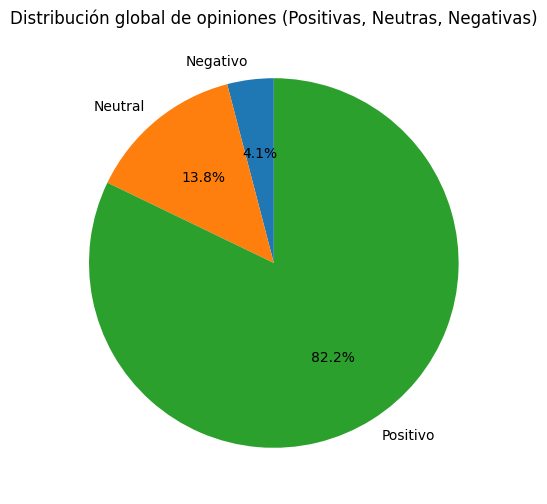

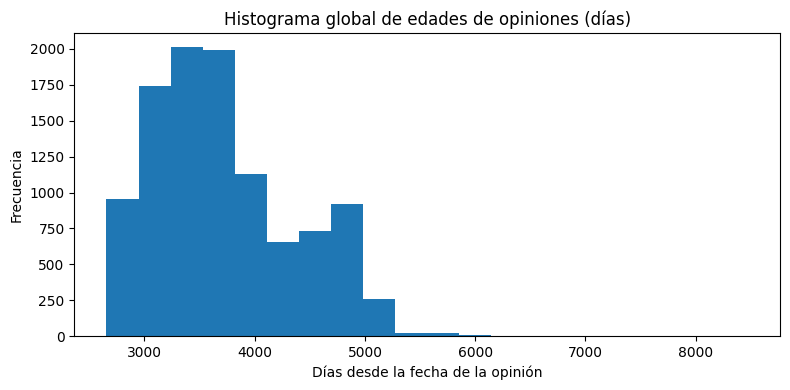

AttributeError: 'LazyFrame' object has no attribute 'pivot'

In [7]:
import polars as pl
import matplotlib.pyplot as plt
from datetime import date

def estadisticos(lf: pl.LazyFrame) -> pl.DataFrame:
    # Paso 1: derivadas que no dependen de fecha_dt
    lf = (
        lf.with_columns([
            pl.col("opinión").fill_null("").str.to_lowercase().str.strip_chars().alias("opinion_limpia"),
            pl.col("opinión").fill_null("").str.len_chars().alias("longitud_opinion"),
            pl.when(pl.col("nacional_ó_internacional").fill_null("").str.to_lowercase().str.contains("nac"))
              .then(pl.lit("Nacional"))
              .otherwise(pl.lit("Internacional"))
              .alias("tipo_visitante"),
            pl.when(pl.col("calificacion_numerica").is_between(4, 5, closed="both"))
              .then(pl.lit("Positivo"))
              .when(pl.col("calificacion_numerica") == 3)
              .then(pl.lit("Neutral"))
              .otherwise(pl.lit("Negativo"))
              .alias("puntuacion_categorica"),
        ])
    )

    # Paso 2: fecha_dt y edad_dias (sin usar .str, para no chocar con Date)
    lf = (
        lf.with_columns([
            pl.col("fecha").cast(pl.Date, strict=False).alias("fecha_dt"),
        ])
        .with_columns([
            (pl.lit(date.today()) - pl.col("fecha_dt")).dt.total_days().alias("edad_dias")
        ])
    )

    # (a) y (b): estadísticos por lugar
    stats = (
        lf.group_by("lugar_turistico")
          .agg([
              pl.col("calificacion_numerica").mean().alias("promedio_calificacion"),
              pl.col("calificacion_numerica").std().alias("desviacion_estandar_calificacion"),
              pl.col("calificacion_numerica").min().alias("minimo_calificacion"),
              pl.col("calificacion_numerica").max().alias("maximo_calificacion"),
              pl.col("longitud_opinion").mean().alias("longitud_promedio_opinion"),
              pl.col("longitud_opinion").std().alias("desviacion_longitud_opinion"),
          ])
          .collect()
    )

    # Barra: promedio y desviación por lugar
    plt.figure(figsize=(12, 6))
    plt.bar(
        stats["lugar_turistico"].to_list(),
        stats["promedio_calificacion"].to_list(),
        yerr=stats["desviacion_estandar_calificacion"].to_list(),
        capsize=5
    )
    plt.title("Estadísticas de Calificaciones por Lugar Turístico")
    plt.xlabel("Lugar Turístico")
    plt.ylabel("Calificación Promedio")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Pastel global de sentimiento
    conteo_global = (
        lf.group_by("puntuacion_categorica")
          .agg(pl.len().alias("conteo"))
          .sort("puntuacion_categorica")
          .collect()
    )
    etiquetas = conteo_global["puntuacion_categorica"].to_list()
    valores = conteo_global["conteo"].to_list()
    plt.figure(figsize=(6, 6))
    plt.pie(valores, labels=etiquetas, autopct="%1.1f%%", startangle=90)
    plt.title("Distribución global de opiniones (Positivas, Neutras, Negativas)")
    plt.show()

    # (c) Histograma global de edades (con limpieza por si hay nulls)
    edades_global = (
        lf.select(pl.col("edad_dias"))
          .collect()["edad_dias"]
          .drop_nans()
          .drop_nulls()
          .to_list()
    )
    if len(edades_global) > 0:
        plt.figure(figsize=(8, 4))
        plt.hist(edades_global, bins=20)
        plt.title("Histograma global de edades de opiniones (días)")
        plt.xlabel("Días desde la fecha de la opinión")
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

    # (d) Visitantes por lugar: barras apiladas
    visitantes_pivot = (
        lf.group_by(["lugar_turistico", "tipo_visitante"])
          .agg(pl.len().alias("n"))
          .pivot(values="n", index="lugar_turistico", columns="tipo_visitante")
          .fill_null(0)
          .collect()
          .sort("lugar_turistico")
    )
    lugares = visitantes_pivot["lugar_turistico"].to_list()
    n_nac = visitantes_pivot.get_column("Nacional").to_list() if "Nacional" in visitantes_pivot.columns else [0]*len(lugares)
    n_int = visitantes_pivot.get_column("Internacional").to_list() if "Internacional" in visitantes_pivot.columns else [0]*len(lugares)

    plt.figure(figsize=(12, 6))
    plt.bar(lugares, n_nac)
    plt.bar(lugares, n_int, bottom=n_nac)
    plt.title("Tipo de visitantes por lugar (Nacional vs Internacional)")
    plt.xlabel("Lugar Turístico")
    plt.ylabel("Número de visitantes")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return stats

print(estadisticos(df_reseñas))